In [1]:
import multimod_dbn as DBN
import torch
import torch.nn as nn
import dataset as dataset
from torchvision import transforms
import IPython
import torch.optim as optim
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import radon, iradon
import matplotlib.animation as animation
from IPython.display import HTML
import os
import torchvision.utils as vutils
import cv2
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/home/emmv1d18/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/emmv1d18/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/emmv1d18/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/emmv1d18/anaconda3/

In [2]:
batch_size = 64
'''data_path = '/home/emmv1d18/Work/Databases/1_object_256x256_uniform_density_v2/'
dset= dataset.dataset(data_path=data_path,
                          data_type='test',
                           transform=transforms.Compose([
                               dataset.Normalize()
                           ]))
                           '''
data_path = '/home/emmv1d18/Work/Databases/2_objects_256x256_opaque_object_logarithmic_evolution/'
dset= dataset.dataset(data_path=data_path,
                          data_type='train',
                           transform=transforms.Compose([
                               dataset.Normalize()
                           ]))
'''data_path = '/home/emmv1d18/Work/Databases/shepp_logan_phantom_256x256/'
dset= dataset.dataset(data_path=data_path,
                          data_type='train',
                           transform=transforms.Compose([
                               dataset.Corrupt_(200)
                           ]))'''
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dset, batch_size=batch_size,shuffle=False)

In [3]:
def res(t):
    return (t-t.mean())/t.std()

In [4]:
class dbn_1m(nn.Module):
    def __init__(self):
        super(dbn, self).__init__()
        self.conv0 = nn.Conv2d(1,40, 2     , stride = 2)
        self.conv1 = nn.Conv2d(40,20,1)
        
    def forward(self, input):        
        batch_size = input.size()[0]
        conv0 = res(F.sigmoid(self.conv0(input)))
        conv1 = res(F.sigmoid(self.conv1(conv0)))
        return conv1

In [5]:
class dbn(nn.Module):
    def __init__(self):
        super(dbn, self).__init__()
        self.conv0   = nn.Conv2d(1,40, 2     , stride = 2)
    
    def forward(self, input):        
        batch_size = input.size()[0]
        conv0 = res(F.sigmoid(self.conv0(input)))
        return conv0
    

In [6]:
class gen(nn.Module):
    def __init__(self):
        super(gen, self).__init__()
        self.conv0 = nn.ConvTranspose2d(20,40,1) 
        self.conv1 = nn.ConvTranspose2d(40,1,2, stride = 2)
        
    def forward(self, input):        
        conv0 = res(self.conv0(input))
        y = res(self.conv1(conv0))
        return y

In [7]:
class joint(nn.Module):
    def __init__(self):
        super(joint, self).__init__()
        self.conv0 = nn.Conv2d(40,20,1)
        self.conv1 = nn.Conv2d(40,20,1, bias =False)
        
    def forward(self, obj, cad):
        h0 = self.conv0(obj)
        h1 = self.conv1(cad)
        return F.sigmoid(h0+h1)

In [8]:
def initialise_obj_dbn(dbn):
    rbm_0 = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm0_2x2')
    dbn.state_dict()['conv0.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(rbm_0['h_bias'])

In [9]:
def initialise_cad_dbn(dbn):
    rbm_0 = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm0_cad_2x2')
    dbn.state_dict()['conv0.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(rbm_0['h_bias'])

In [10]:
def initialise_joint(joint):
    model = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm_joint_bold_v2')
    joint.state_dict()['conv0.weight'].data.copy_(model['0']['weights'])
    joint.state_dict()['conv0.bias'].data.copy_(model['h_bias'])
    joint.state_dict()['conv1.weight'].data.copy_(model['1']['weights'])


In [11]:
def initialise_obj_gen(dbn):
    rbm_0 = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm0_2x2')
    model = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm_joint_bold_v2')
    dbn.state_dict()['conv0.weight'].data.copy_(model['0']['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(model['0']['v_bias'])
    dbn.state_dict()['conv1.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv1.bias'].data.copy_(rbm_0['v_bias'])


In [12]:
def initialise_cad_gen(dbn):
    rbm_0 = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm0_cad_2x2')
    model = torch.load('/home/emmv1d18/Work/RBM_for_inpainting/saves_thomas/rbm_joint_bold_v2')
    dbn.state_dict()['conv0.weight'].data.copy_(model['1']['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(model['1']['v_bias'])
    dbn.state_dict()['conv1.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv1.bias'].data.copy_(rbm_0['v_bias'])

In [13]:
obj_modality = dbn()
cad_modality = dbn()
joint_layer  = joint()
obj_generator = gen()
cad_generator = gen()
initialise_obj_dbn(obj_modality)
initialise_cad_dbn(cad_modality)
initialise_joint(joint_layer)
#obj_generator.load_state_dict(torch.load('./saves_new_architecture/generator_v6_w_relu.pth'))
initialise_obj_gen(obj_generator)
#initialise_cad_gen(cad_generator)
obj_modality.to(0)
cad_modality.to(1)
joint_layer.to('cpu')
obj_generator.to(0)
cad_generator.to(1)

gen(
  (conv0): ConvTranspose2d(20, 40, kernel_size=(1, 1), stride=(1, 1))
  (conv1): ConvTranspose2d(40, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [14]:
# Losses definition
L1_loss   = nn.L1Loss()
L2_loss   = nn.MSELoss()
img_list = []
err_list = []
h_list   = []

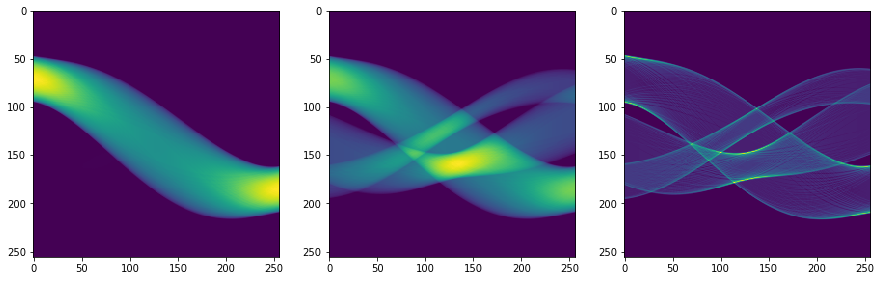

In [39]:
im = 0
data = next(iter(dataloader))
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(data['obj_cor'][im][0])
fig.add_subplot(rows, columns, 2)
plt.imshow(data['obj_tgt'][im][0])
fig.add_subplot(rows, columns, 3)
plt.imshow(data['cad'][im][0])
plt.savefig('scene_with_opaque_object.png', bbox_inches='tight')
plt.show()

In [27]:
n_epochs = 5
lr = 1e-3
beta = 0.5
# Optimizr definition
optimizer = optim.Adam(obj_generator.parameters(), lr=lr, betas=(beta, 0.999))
for epoch in range(n_epochs):
    tic = time.time()
    i =0
    epoch_error = 0
    for data in dataloader:
        obj_generator.zero_grad()
        obj = data['obj_cor'].cuda(device = 0).float()
        obj_ref = data['obj_tgt'].cuda(device = 0).float()
        cad = data['cad'].cuda(device = 1).float()
        h = joint_layer(obj_modality(obj).detach().cpu(), cad_modality(cad).detach().cpu())
        x = obj_generator(h.cuda(device = 0))
        error = L2_loss(x, obj_ref)
        error.backward()
        tac = time.time()
        optimizer.step()
        epoch_error += error.detach().cpu() 
        i+=1
    epoch_error /= i
    print('----------------------------')
    print('Time : %.2f, Epoch : %s, Error : %.4f' % (tac-tic, epoch, epoch_error))

----------------------------
Time : 54.01, Epoch : 0, Error : 0.7030
----------------------------
Time : 54.37, Epoch : 1, Error : 0.7026
----------------------------
Time : 54.20, Epoch : 2, Error : 0.7026
----------------------------
Time : 54.65, Epoch : 3, Error : 0.7021
----------------------------
Time : 54.27, Epoch : 4, Error : 0.7015


In [28]:
torch.save(obj_generator.state_dict(), './saves_generator/generator_opaque.pth')

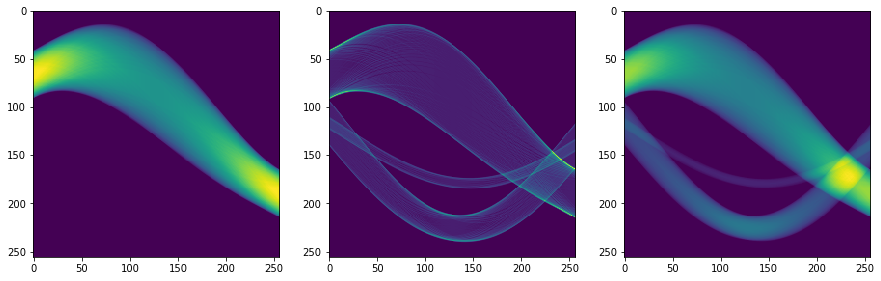

In [51]:
n_frames = 256
theta = np.linspace(0., 180., n_frames, endpoint=False)
im = 7
data = next(iter(dataloader))
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 1
'''plt.matshow(cad[im][0].detach().cpu())
plt.matshow(obj[im][0].detach().cpu())
plt.matshow(obj_ref[im][0].detach().cpu())'''
fig.add_subplot(rows, columns, 1)
plt.imshow(obj[im][0].detach().cpu())
fig.add_subplot(rows, columns, 2)
plt.imshow(cad[im][0].detach().cpu())
fig.add_subplot(rows, columns, 3)
plt.imshow(obj_ref[im][0].detach().cpu())
plt.savefig('scene_with_opaque_object.png', bbox_inches='tight')
plt.show()

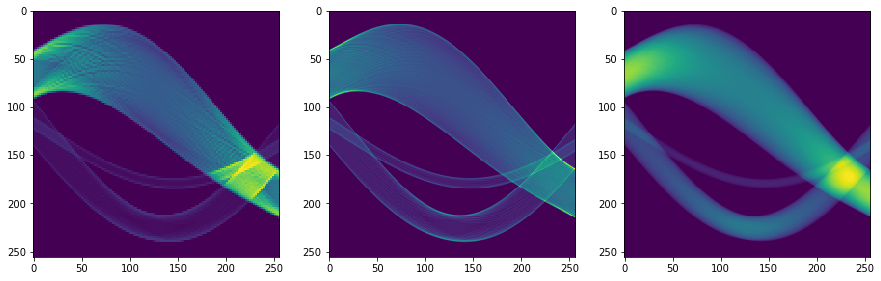

In [61]:
fig=plt.figure(figsize=(15,15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(x[im][0].detach().cpu())
fig.add_subplot(rows, columns, 2)
plt.imshow(cad[im][0].detach().cpu()+obj[im][0].detach().cpu())
fig.add_subplot(rows, columns, 2)
plt.imshow(obj_ref[im][0].detach().cpu())
plt.savefig('inferred_sinogram_opaque.png', bbox_inches='tight')

tensor(0.9052)
tensor(0.2511)
tensor(0.0006)
tensor(8.2724e-05)


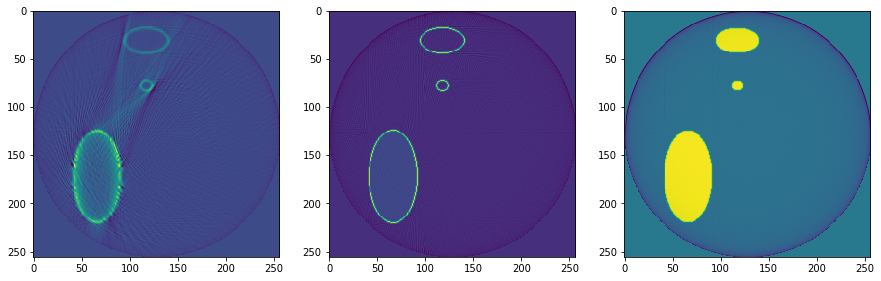

In [66]:
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 3)
plt.imshow(iradon(obj_ref[im][0].detach().cpu(), theta))
fig.add_subplot(rows, columns, 2)
plt.imshow(iradon(cad[im][0].detach().cpu()+obj[im][0].detach().cpu(), theta))
fig.add_subplot(rows, columns, 1)
plt.imshow(iradon(x[im][0].detach().cpu(), theta))
plt.savefig('inferred_reconstruction_opaque.png', bbox_inches='tight')
print(L2_loss(cad[im][0].detach().cpu()+obj[im][0].detach().cpu(), obj_ref[im][0].detach().cpu()))
print(L2_loss(x[im][0].detach().cpu(), obj_ref[im][0].detach().cpu()))
print(L2_loss(torch.Tensor(iradon(cad[im][0].detach().cpu()+obj[im][0].detach().cpu(), theta)), torch.Tensor(iradon(obj_ref[im][0].detach().cpu(), theta))))
print(L2_loss(torch.Tensor(iradon(x[im][0].detach().cpu(),                             theta)), torch.Tensor(iradon(obj_ref[im][0].detach().cpu(), theta))))

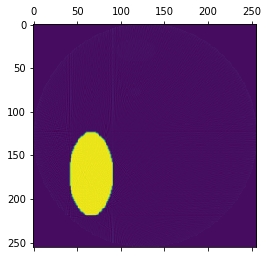

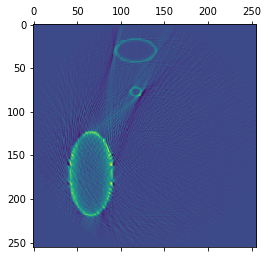

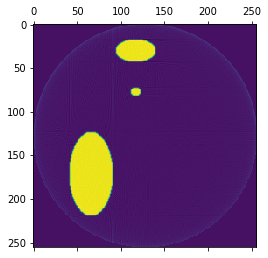

In [37]:
irad_ = iradon((obj-obj.min())[im][0].detach().cpu().view((256,256)), theta)
irad = iradon((x-x.min())[im][0].detach().cpu().view((256,256)), theta)
plt.matshow(irad_)
plt.matshow(irad)
ref = iradon((data['obj_tgt']-data['obj_tgt'].min())[im][0].view(256,256), theta)
plt.matshow(ref)

In [ ]:
l = data['list']
l

In [ ]:
x_  = x.detach().cpu().view((8,256,256))
obj_= obj.detach().cpu().view((8,256,256))
plt.matshow(obj_[3])
plt.matshow(x_[3])
ref = data['object_reference']
plt.matshow(ref.view((8,256,256))[3])

In [ ]:
l = data['list']
print(len(l))

In [ ]:
M = np.ones((1,1,256,256))
location = 10
size =10
M[0,0,:,location-size:location+size] = 0

In [ ]:
plt.matshow(M[0][0])